# Framework

- Spreads 
    - Crack - (Gasoline - WTI) (RB - CL)
    - ~~Crush - (Soybeans - Soyoil) (ZS - ZL)~~
    - ~~Spark - (Gulf Coast LNG Export Futures - ERCOT SOUTH 345 KV HUB) (LNG - YUEF1)~~
    - ~~Frac - (Natural Gas - Heating Oil) (LNG - H0)~~

- Rollover Method
    - By Same Expiration Date

- Filters
    - Unfiltered
    - Threshold
    - Correlation
    - Volatility

- Models
    - Fair value model
        - Johansen Portfolio
        - TAR Model
    - [Multi Layer Perceptron](#mlp) 
    - [Long Short Term Memory Network](#rnn)
    - Higher-Order Neural Network
        - Single Layer
            - [Feature Expander](#flnn)
        - Multi layer
            - [Pi Sigma Neural Network](#pisigma)

- Ensemble
    - RegressorCommittee

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
from IPython.display import Image

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from arbitragelab.cointegration_approach.johansen import JohansenPortfolio
from arbitragelab.ml_approach.regressor_committee import RegressorCommittee
from arbitragelab.ml_approach.neural_networks import MultiLayerPerceptron, RecurrentNeuralNetwork, PiSigmaNeuralNetwork
from arbitragelab.util.spread_modeling_helper import SpreadModelingHelper

import warnings
warnings.filterwarnings('ignore')

In [4]:
wti_contract_df = pd.read_csv('./data/NonNegative_CL_forward_roll.csv').set_index('Dates')

rbob_contract_df = pd.read_csv('./data/NonNegative_nRB_forward_roll.csv').set_index('Dates')

working_df = pd.concat([wti_contract_df, rbob_contract_df], axis=1)
working_df.index = pd.to_datetime(working_df.index) 
working_df.columns = ['wti', 'gasoline']

working_df.dropna(inplace=True)
working_df

,wti,gasoline
Dates,,
2006-01-03,1.034404,1.026552
2006-01-04,1.038991,1.048563
2006-01-05,1.028670,1.044253
2006-01-06,1.051933,1.060632
2006-01-09,1.040301,1.033046
...,...,...
2019-12-25,0.431366,1.056159
2019-12-26,0.435390,1.072488
2019-12-27,0.435672,1.068574


In [5]:
johansen_portfolio = JohansenPortfolio()
johansen_portfolio.fit(working_df)
sprd = johansen_portfolio.construct_mean_reverting_portfolio(working_df).pct_change()

# Multi Layer Perceptron  <a class="anchor" id="mlp"></a>

0.4137200832933017


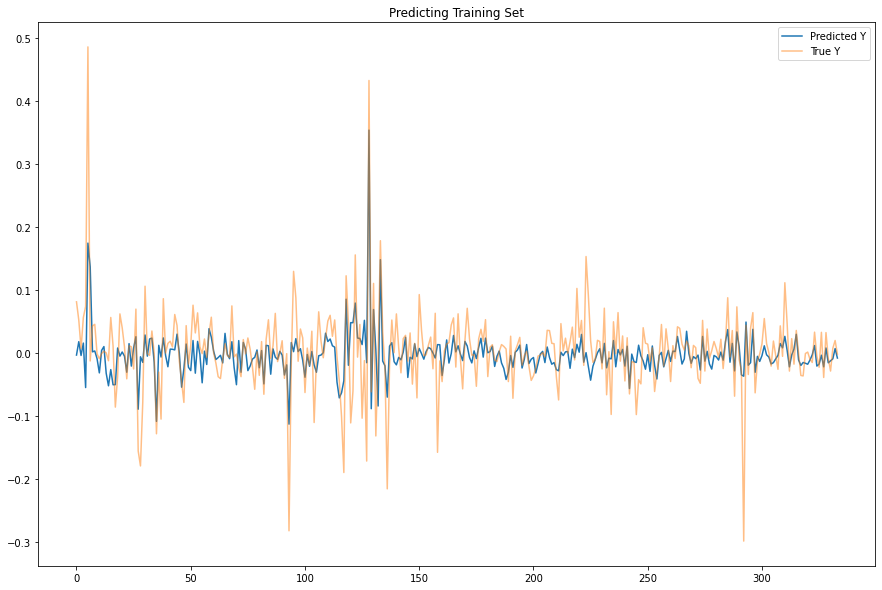

0.2769130335251506


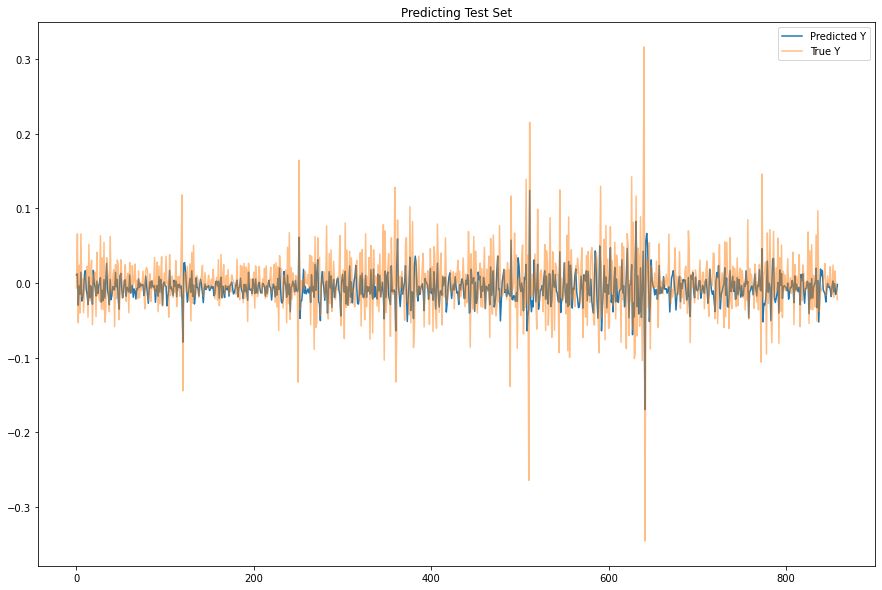

0.3102091245434513


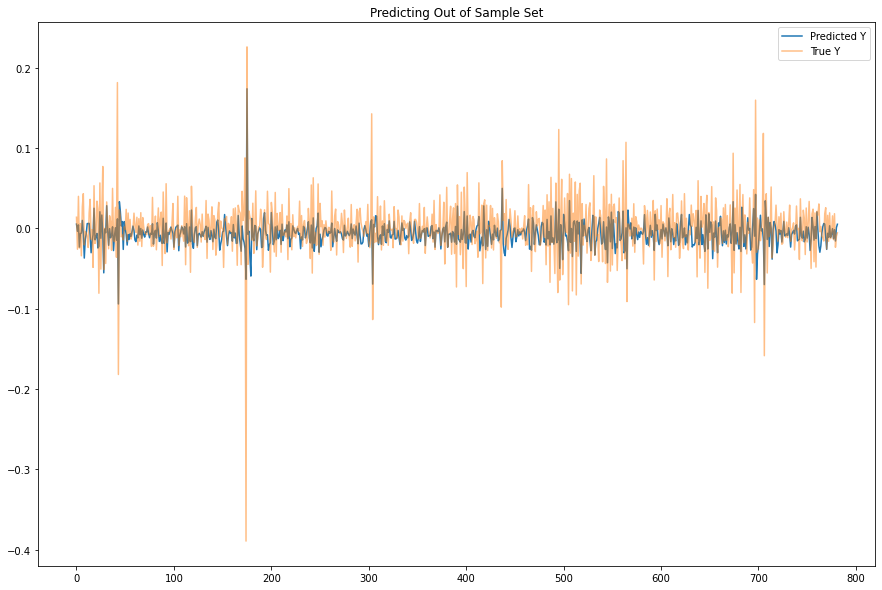

In [7]:
helper = SpreadModelingHelper(sprd, False, unique_sampling=True)

_, frame_size = helper.input_train.shape

mlp_params = {'frame_size': frame_size, 'hidden_size': 8, 'num_outputs': 1, 'loss_fn': "mean_squared_error", 
                    'optmz': "adam", 'metrics': [], 'hidden_layer_activation_function': "sigmoid",
                    'output_layer_act_func': "linear"}

committee = RegressorCommittee(mlp_params, num_committee=10, epochs=500, verbose=False)
committee.fit(helper.input_train, helper.target_train)

train_set, train_pred, test_set, test_pred, oos_set, oos_pred = helper.plot_model_results(committee)

In [8]:
helper.get_metrics(working_df)

,Filtering Method,Annual Returns,Std Dev,Set
0,unfiltered,0.034209,0.065725,train
1,std_threshold,-0.013777,0.089892,train
2,corr_filter,0.030659,0.037317,train
3,std_vol_filter,0.059453,0.098014,train
4,corr_vol_filter,0.033047,0.058742,train
0,unfiltered,-0.177544,0.043352,test
1,std_threshold,-0.037302,0.029879,test
2,corr_filter,-0.144011,0.066007,test
3,std_vol_filter,-0.003339,0.004822,test
4,corr_vol_filter,-0.006358,0.044348,test


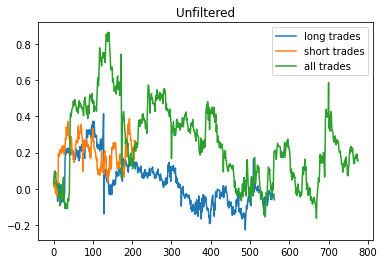

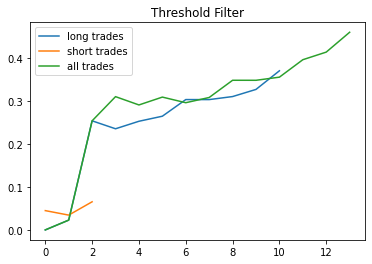

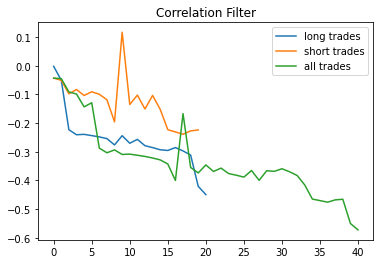

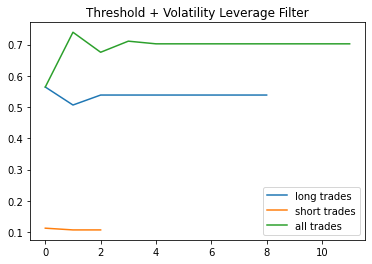

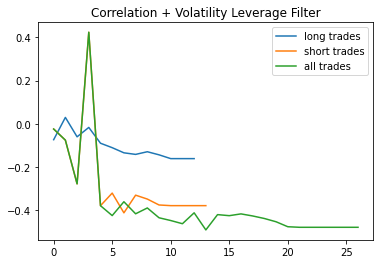

In [9]:
helper.get_filtering_results(oos_set, oos_pred, test_pred, working_df);

# Functional Link Neural Network <a class="anchor" id="flnn"></a>

0.3512985058233138


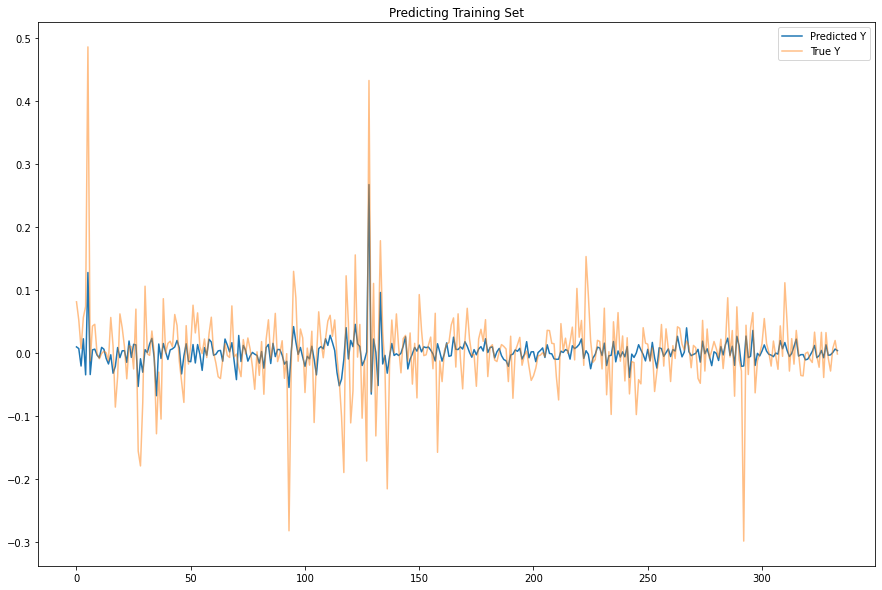

0.2344084159068125


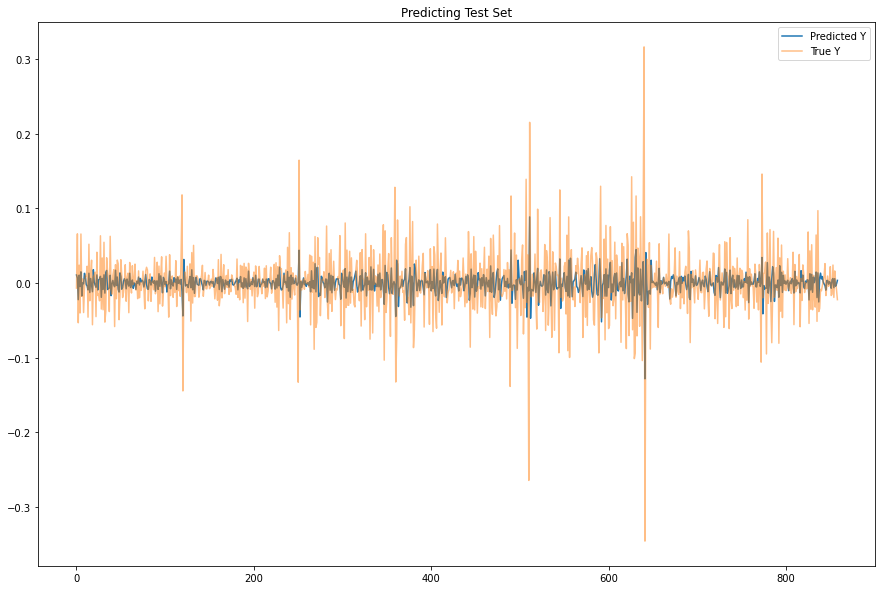

0.27714401377683995


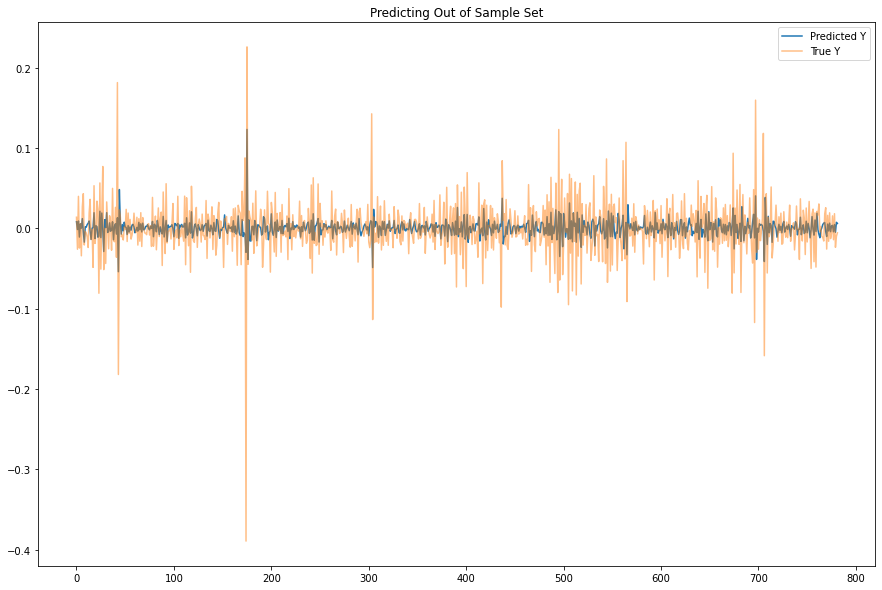

In [10]:
helper = SpreadModelingHelper(sprd, True, unique_sampling=True)

_, frame_size = helper.input_train.shape

honn_params = {'frame_size': frame_size, 'hidden_size': 2, 'num_outputs': 1, 'loss_fn': "mean_squared_error", 
                    'optmz': "adam", 'metrics': [], 'hidden_layer_activation_function': "relu",
                    'output_layer_act_func': "linear"}

committee = RegressorCommittee(honn_params, regressor_class='MultiLayerPerceptron',
                               num_committee=10, epochs=500, verbose=False)
committee.fit(helper.input_train, helper.target_train)

train_set, train_pred, test_set, test_pred, oos_set, oos_pred = helper.plot_model_results(committee)

In [11]:
helper.get_metrics(working_df)

,Filtering Method,Annual Returns,Std Dev,Set
0,unfiltered,0.035840,0.065835,train
1,std_threshold,-0.028548,0.107120,train
2,corr_filter,0.030659,0.037317,train
3,std_vol_filter,-0.038203,0.138254,train
4,corr_vol_filter,0.033047,0.058742,train
0,unfiltered,-0.195508,0.043462,test
1,std_threshold,0.009268,0.044399,test
2,corr_filter,-0.144011,0.066007,test
3,std_vol_filter,-0.027287,0.047799,test
4,corr_vol_filter,-0.506502,0.146102,test


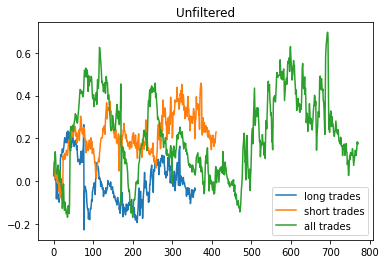

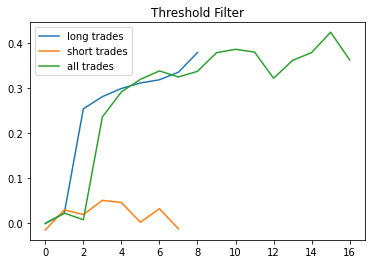

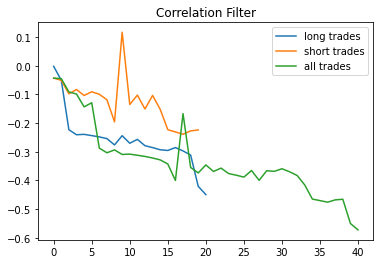

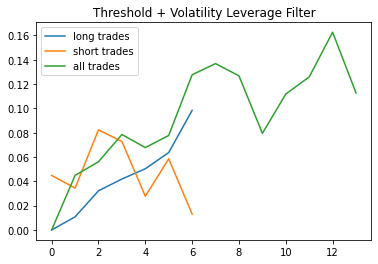

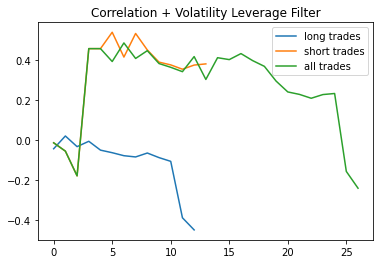

In [12]:
helper.get_filtering_results(oos_set, oos_pred, test_pred, working_df);

# Pi Sigma Neural Network <a class="anchor" id="pisigma"></a>

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
-0.048865073350256916


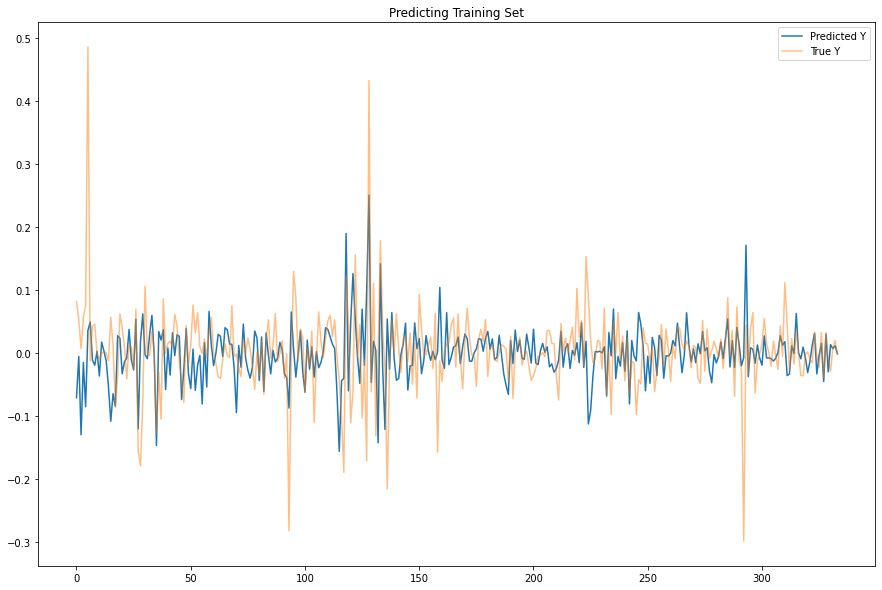

-0.16537876219756087


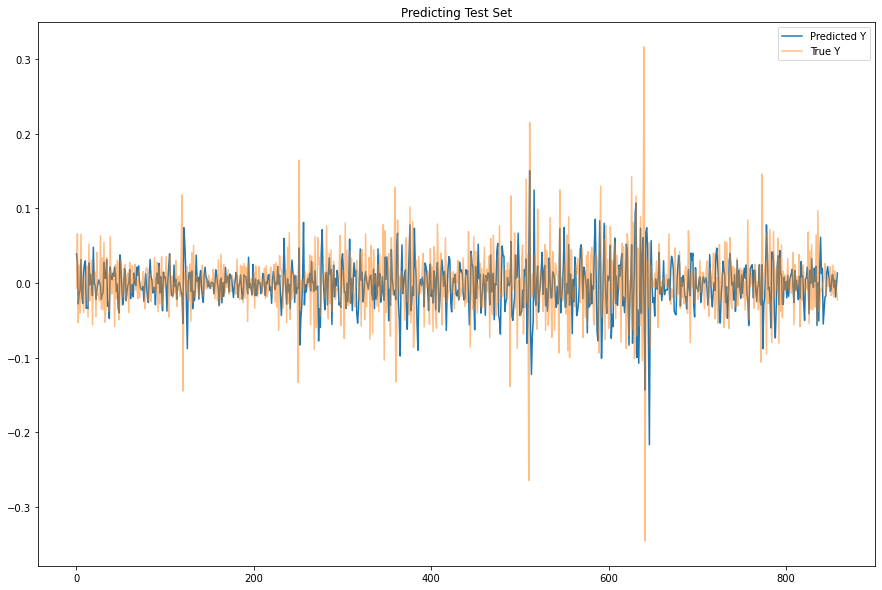

-0.07236761550791271


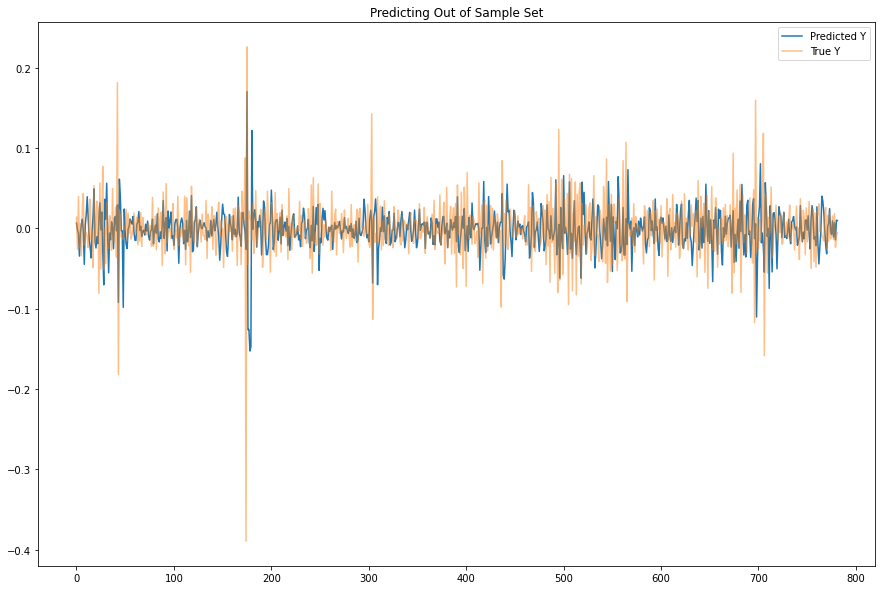

In [13]:
helper = SpreadModelingHelper(sprd, False, unique_sampling=True)

_, frame_size = helper.input_train.shape

ps_params = {'frame_size': frame_size, 'hidden_size': 6, 'num_outputs': 1, 'loss_fn': "mean_squared_error", 
                    'optmz': "adam", 'metrics': [], 'hidden_layer_activation_function': "linear",
                    'output_layer_act_func': "tanh"}

committee = RegressorCommittee(ps_params, regressor_class='PiSigmaNeuralNetwork',
                               num_committee=10, epochs=500, verbose=False)
committee.fit(helper.input_train, helper.target_train)

train_set, train_pred, test_set, test_pred, oos_set, oos_pred = helper.plot_model_results(committee)

In [14]:
helper.get_metrics(working_df)

,Filtering Method,Annual Returns,Std Dev,Set
0,unfiltered,0.036441,0.065848,train
1,std_threshold,0.007731,0.146627,train
2,corr_filter,0.030659,0.037317,train
3,std_vol_filter,0.058723,0.231416,train
4,corr_vol_filter,0.025215,0.046975,train
0,unfiltered,-0.165054,0.043641,test
1,std_threshold,-0.027052,0.057064,test
2,corr_filter,-0.144011,0.066007,test
3,std_vol_filter,-0.051312,0.069813,test
4,corr_vol_filter,-0.145470,0.083815,test


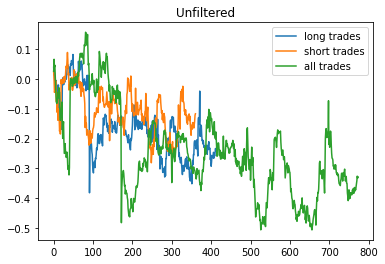

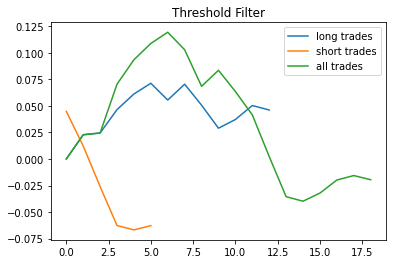

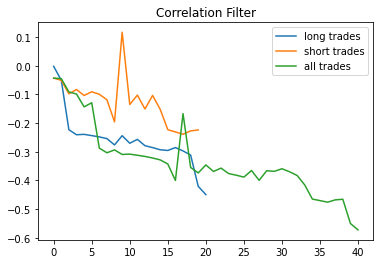

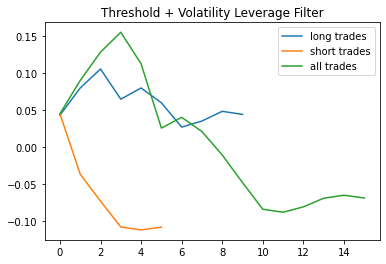

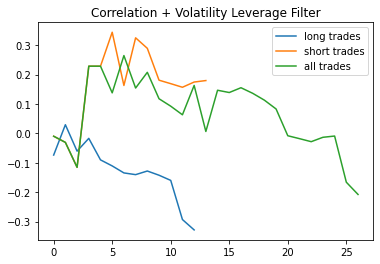

In [15]:
helper.get_filtering_results(oos_set, oos_pred, test_pred, working_df);

# Recurrent Neural Network <a class="anchor" id="rnn"></a>

0.5675041073400311


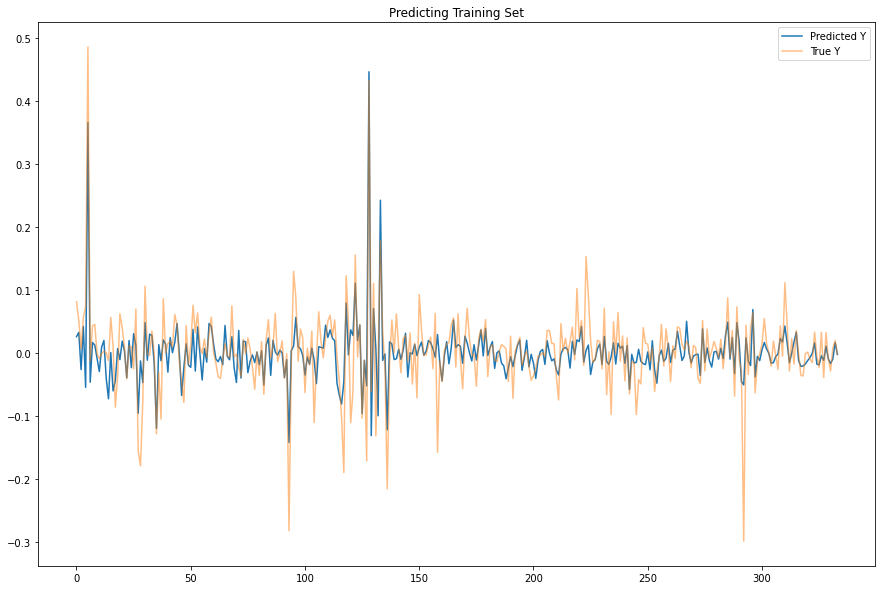

0.37991725379571584


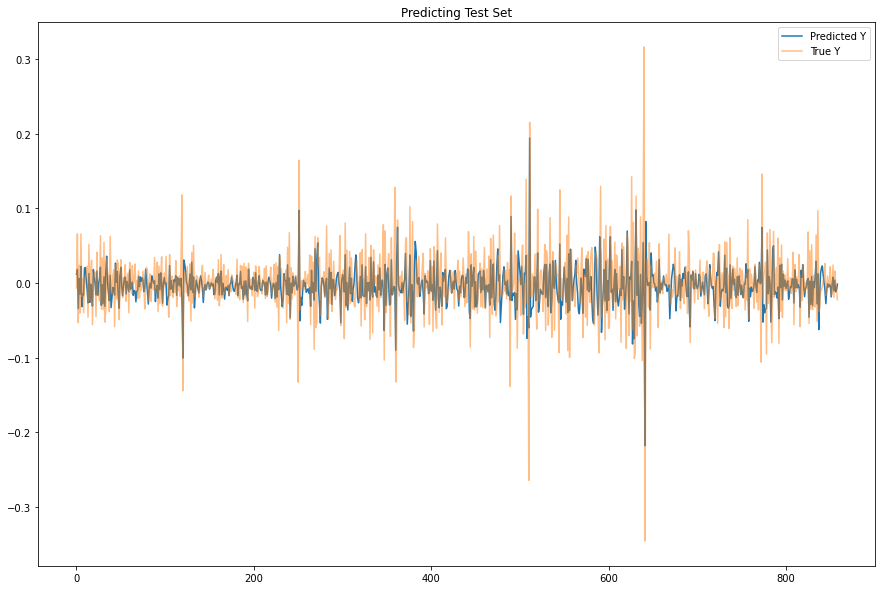

0.4176725672733089


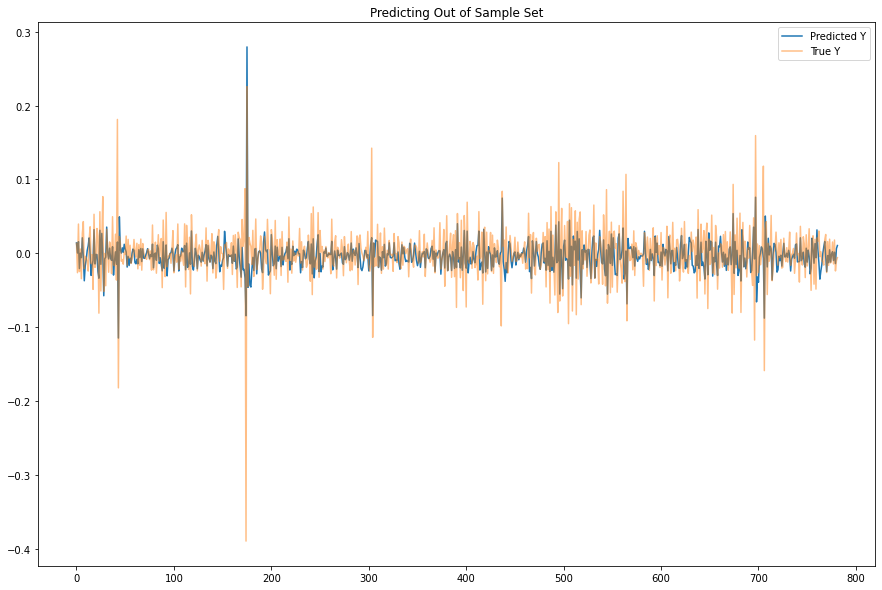

In [16]:
helper = SpreadModelingHelper(sprd, False, unique_sampling=True)

X_rnn_train = helper.input_train.reshape((helper.input_train.shape[0], helper.input_train.shape[1], 1))
X_rnn_test = helper.input_test.reshape((helper.input_test.shape[0], helper.input_test.shape[1], 1))
X_rnn_oos = helper.input_oos.reshape((helper.input_oos.shape[0], helper.input_oos.shape[1], 1))

_, frame_size, no_features = X_rnn_train.shape

rnn_params = {'input_shape': (frame_size, no_features), 'num_outputs': 1, 'loss_fn': "mean_squared_error", 
                    'optmz': "adam", 'metrics': [], 'hidden_layer_activation_function': "relu",
                    'output_layer_act_func': "linear"}

committee = RegressorCommittee(rnn_params, regressor_class='RecurrentNeuralNetwork',
                               num_committee=10, epochs=500, verbose=False)
committee.fit(X_rnn_train, helper.target_train)

helper.input_train = X_rnn_train
helper.input_test = X_rnn_test
helper.input_oos = X_rnn_oos

train_set, train_pred, test_set, test_pred, oos_set, oos_pred = helper.plot_model_results(committee)

In [17]:
helper.get_metrics(working_df)

,Filtering Method,Annual Returns,Std Dev,Set
0,unfiltered,0.043543,0.066211,train
1,std_threshold,-0.012395,0.090956,train
2,corr_filter,0.030659,0.037317,train
3,std_vol_filter,0.117988,0.081399,train
4,corr_vol_filter,0.037523,0.060044,train
0,unfiltered,-0.178272,0.043735,test
1,std_threshold,-0.049391,0.026197,test
2,corr_filter,-0.144011,0.066007,test
3,std_vol_filter,-0.034154,0.029494,test
4,corr_vol_filter,-0.098398,0.057396,test


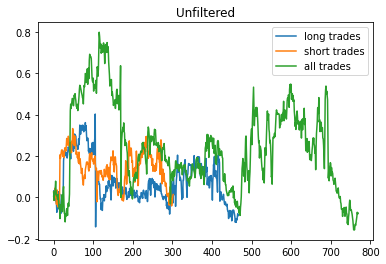

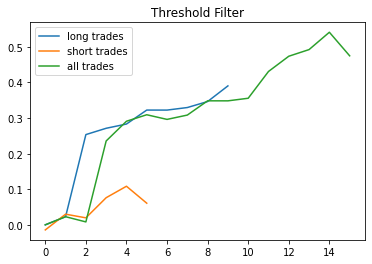

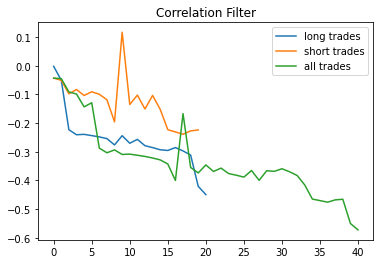

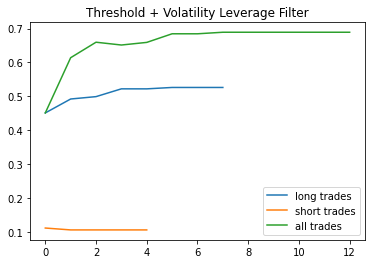

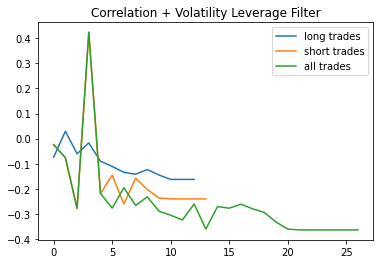

In [18]:
helper.get_filtering_results(oos_set, oos_pred, test_pred, working_df);